<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

13.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 161197304 bytes
User uploaded file "locations_categorical_features.csv" with length 27802193 bytes
User uploaded file "validation_data.csv" with length 5499459 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [87]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
562389,99996800_303056370_189735890,PO16 9PA,FAREHAM
562390,99998470_302856560_189531620,PO16 9UH,FAREHAM
562391,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH
562392,9999870_270237390_170268490,SE21 7EU,SOUTHWARK


In [111]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60250.00000,56187.50000,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.66667,79000.00000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.66667,64341.66667,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.66670,101666.66670,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0
4,1,L,F,34.0,94.537513,0.458854,63.0,8.1,7.7,25562.50000,25000.00000,9,28437687000,4781898000,12633222000,53.420228,-2.966120,33000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1135504,47,L,T,12.0,72.452903,1.542007,39.0,8.5,7.5,37625.00000,40499.37500,14,27236922000,1773271000,12075555000,53.502594,-2.516861,79000.0
1135505,48,F,S,1.0,0.000000,0.000000,0.0,0.0,0.0,40000.00000,50500.00000,16,21104985000,21110074000,12654123000,51.674615,-3.212091,53000.0
1135506,55,F,T,1.0,0.000000,0.000000,0.0,0.0,0.0,41333.33333,45416.66667,14,27804846000,6355589000,11793603000,53.245090,-3.123599,70000.0
1135507,81,L,T,1.0,88.443148,2.462274,25.0,9.7,7.7,54000.00000,56650.00000,16,28051597900,2906478000,14022715000,53.734079,-2.140287,95000.0


In [112]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.00000,330000.00000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.33330,119166.66670,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.00000,80000.00000,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.00000,279821.42860,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.00000,42908.33333,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38382,11,F,D,12.0,84.705333,0.424683,42.0,7.8,6.7,48583.33333,57500.00000,26,25966523900,3773829000,12954650000,53.642111,-1.748224,415000.0
38383,11,F,D,45.0,90.592648,0.935044,53.0,10.7,8.1,70250.00000,79583.33333,26,15885462000,11716322000,410900900,52.445938,-1.924921,900000.0
38384,12,F,D,1.0,14.057832,4.594217,10.0,10.6,10.5,98833.33333,92500.00000,26,11001257000,15043775000,5857544000,52.327517,-1.079233,840000.0
38385,13,F,D,42.0,86.608374,0.258647,51.0,9.7,8.2,40875.00000,59333.33333,26,16388710900,11226349000,417089900,52.486194,-1.966257,660000.0


In [113]:
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1000000) ]
df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1000000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]

In [114]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [115]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [116]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [117]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [118]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
845572,3,2,3,17.0,84.020170,1.021013,39.0,8.7,7.7,47000.00000,46750.0000,20,34531728000,13314017900,23260608000,54.542391,-1.307667,266000.0
441112,3,2,2,14.0,94.738698,0.604684,48.0,7.3,6.7,92708.33333,97750.0000,22,9274515000,30285725000,18990281000,50.866338,-1.007428,225000.0
680588,3,2,2,16.0,112.279252,0.807636,27.0,11.4,9.8,37958.33333,35000.0000,9,38602759000,16787123000,27171546000,54.906011,-1.398372,103500.0
1044994,4,2,4,4.0,140.852143,1.393085,36.0,9.4,7.8,40000.00000,40000.0000,3,35906251900,13478023000,23972667000,54.628406,-1.584959,210000.0
338118,2,2,2,32.0,59.359499,0.443723,20.0,10.5,8.4,126666.66670,126666.6667,3,2025869900,27643559000,17916653000,51.452266,0.107893,307500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666557,3,1,1,62.0,97.893089,0.646067,47.0,9.8,8.2,190000.00000,197500.0000,5,1196216900,26043481000,16379714000,51.571328,-0.021965,390000.0
944152,4,2,4,1.0,24.660630,4.702072,19.0,9.0,8.8,57500.00000,58000.0000,8,17874230000,12234008000,11620724000,53.106310,-0.520558,330000.0
1004714,4,2,4,7.0,88.618659,0.935240,23.0,9.4,8.7,143750.00000,157500.0000,11,3231528000,22818736000,12859117000,51.742084,-0.456512,550000.0
643989,3,2,4,7.0,95.952041,2.242548,36.0,8.4,7.5,125000.00000,141666.6667,9,7541075000,32912415000,22189419000,50.837439,-0.080200,450000.0


In [119]:
dataset = df_train_test_data.values
dataset

array([[3, '2', '3', ..., 54.542391, -1.307667, 266000.0],
       [3, '2', '2', ..., 50.866338, -1.007428, 225000.0],
       [3, '2', '2', ..., 54.906011, -1.398372, 103500.0],
       ...,
       [4, '2', '4', ..., 51.742084000000006, -0.456512, 550000.0],
       [3, '2', '4', ..., 50.837439, -0.0802, 450000.0],
       [4, '2', '2', ..., 51.364267, -0.262293, 535000.0]], dtype=object)

In [120]:
X1 = dataset[:,0:17]
Y1 = dataset[:,17]
#all features

In [121]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [122]:
X_Validation=validation_dataset[:,0:17]
Y_Validation =validation_dataset[:,17]

In [123]:
from sklearn import preprocessing

In [124]:
min_max_scaler = preprocessing.MinMaxScaler()

In [125]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.5       , 1.        , 0.66666667, ..., 0.61836352, 0.78550908,
        0.58922969],
       [0.5       , 1.        , 0.33333333, ..., 0.50450928, 0.15186252,
        0.62947657],
       [0.5       , 1.        , 0.33333333, ..., 0.72263582, 0.84818678,
        0.57707073],
       ...,
       [0.75      , 1.        , 1.        , ..., 0.34104195, 0.30281612,
        0.70332656],
       [0.5       , 1.        , 1.        , ..., 0.58980378, 0.14688115,
        0.75377098],
       [0.75      , 1.        , 0.33333333, ..., 0.44519497, 0.23769126,
        0.72936151]])

In [126]:

print(min(Y1))
print(max(Y1))

14500.0
999999.0


In [127]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44349627, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45727387, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.5055068 , 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51765457, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58455457, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62369645, 0.13666815,
        0.77824104]])

In [128]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
999000.0


In [129]:
from sklearn.model_selection import train_test_split

In [130]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [131]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(923469, 17) (102608, 17) (923469,) (102608,)


In [132]:
from sklearn.ensemble import RandomForestRegressor

In [133]:
regr1 = RandomForestRegressor(max_depth=12, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [134]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [136]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,3.0,2.0,2.0,8.0,65.819334,1.948241,35.0,9.8,7.6,41375.00000,40875.00000,7.0,2.323450e+10,6.539029e+09,1.205458e+10,53.493740,-1.263117,133000,98591.459852,34408.5,1.18395e+09,34408.5,232344980_65390289_120545820
1,3.0,2.0,2.0,7.0,86.215310,0.551428,9.0,13.9,14.1,75000.00000,75000.00000,21.0,2.641340e+10,3.464332e+10,2.510871e+10,50.471489,-3.559748,211500,196099.585971,15400.4,2.37173e+08,15400.4,264133999_346433220_251087120
2,3.0,2.0,2.0,5.0,135.340267,0.396438,100.0,0.2,0.7,100000.00000,99833.33333,18.0,1.364810e+10,2.283456e+10,1.180272e+10,51.428812,-2.133476,375000,259020.311090,115980,1.34513e+10,115980,136481000_228345640_118027200
3,2.0,1.0,1.0,13.0,78.808332,0.708815,22.0,11.9,10.5,65666.66667,77500.00000,10.0,4.001522e+10,1.749086e+10,2.817040e+10,55.008088,-1.604707,137000,127817.356533,9182.64,8.43209e+07,9182.64,400152240_174908580_281704010
4,3.0,2.0,2.0,6.0,124.903074,0.169697,31.0,11.2,9.1,62666.66667,67500.00000,11.0,2.627515e+10,3.452445e+10,2.497596e+10,50.480071,-3.544738,195000,168527.478974,26472.5,7.00794e+08,26472.5,262751479_345244490_249759610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102603,3.0,2.0,2.0,10.0,42.030239,0.660189,12.0,10.7,9.9,85000.00000,78500.00000,25.0,1.462226e+10,1.144583e+10,4.983003e+09,52.656123,-1.226686,214000,207210.691708,6789.31,4.60947e+07,6789.31,146222600_114458270_49830030
102604,5.0,2.0,2.0,10.0,54.917068,1.834376,44.0,9.0,8.5,50000.00000,47000.00000,23.0,2.791140e+10,3.190292e+09,1.240310e+10,53.478729,-2.733351,230000,175013.098110,54986.9,3.02356e+09,54986.9,279113990_31902920_124031000
102605,3.0,2.0,3.0,7.0,79.603857,1.273047,48.0,7.5,6.1,49166.66667,45833.33333,10.0,2.310514e+10,7.229043e+09,1.240185e+10,53.501790,-1.159042,110000,130534.392440,-20534.4,4.21661e+08,20534.4,231051370_72290430_124018500
102606,3.0,2.0,3.0,1.0,105.841229,1.398207,23.0,9.4,8.7,70000.00000,73333.33333,18.0,2.397478e+10,2.975328e+10,2.051856e+10,50.912236,-3.473413,129950,205871.857217,-75921.9,5.76413e+09,75921.9,239747790_297532820_205185600


In [137]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,3.0,2.0,2.0,8.0,65.819334,1.948241,35.0,9.8,7.6,41375.00000,40875.00000,7.0,2.323450e+10,6.539029e+09,1.205458e+10,53.493740,-1.263117,133000,98591.459852,34408.5,1.18395e+09,34408.5,232344980_65390289_120545820,S64 0FD,DONCASTER,S64
1,3.0,2.0,2.0,7.0,86.215310,0.551428,9.0,13.9,14.1,75000.00000,75000.00000,21.0,2.641340e+10,3.464332e+10,2.510871e+10,50.471489,-3.559748,211500,196099.585971,15400.4,2.37173e+08,15400.4,264133999_346433220_251087120,TQ2 6EU,TORBAY,TQ2
2,3.0,2.0,2.0,5.0,135.340267,0.396438,100.0,0.2,0.7,100000.00000,99833.33333,18.0,1.364810e+10,2.283456e+10,1.180272e+10,51.428812,-2.133476,375000,259020.311090,115980,1.34513e+10,115980,136481000_228345640_118027200,SN15 2NG,WILTSHIRE,SN15
3,2.0,1.0,1.0,13.0,78.808332,0.708815,22.0,11.9,10.5,65666.66667,77500.00000,10.0,4.001522e+10,1.749086e+10,2.817040e+10,55.008088,-1.604707,137000,127817.356533,9182.64,8.43209e+07,9182.64,400152240_174908580_281704010,NE3 1TF,NEWCASTLE UPON TYNE,NE3
4,3.0,2.0,2.0,6.0,124.903074,0.169697,31.0,11.2,9.1,62666.66667,67500.00000,11.0,2.627515e+10,3.452445e+10,2.497596e+10,50.480071,-3.544738,195000,168527.478974,26472.5,7.00794e+08,26472.5,262751479_345244490_249759610,TQ2 7NJ,TORBAY,TQ2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102603,3.0,2.0,2.0,10.0,42.030239,0.660189,12.0,10.7,9.9,85000.00000,78500.00000,25.0,1.462226e+10,1.144583e+10,4.983003e+09,52.656123,-1.226686,214000,207210.691708,6789.31,4.60947e+07,6789.31,146222600_114458270_49830030,LE6 0YP,HINCKLEY AND BOSWORTH,LE6
102604,5.0,2.0,2.0,10.0,54.917068,1.834376,44.0,9.0,8.5,50000.00000,47000.00000,23.0,2.791140e+10,3.190292e+09,1.240310e+10,53.478729,-2.733351,230000,175013.098110,54986.9,3.02356e+09,54986.9,279113990_31902920_124031000,WA11 7DF,ST HELENS,WA11
102605,3.0,2.0,3.0,7.0,79.603857,1.273047,48.0,7.5,6.1,49166.66667,45833.33333,10.0,2.310514e+10,7.229043e+09,1.240185e+10,53.501790,-1.159042,110000,130534.392440,-20534.4,4.21661e+08,20534.4,231051370_72290430_124018500,DN4 9DT,DONCASTER,DN4
102606,3.0,2.0,3.0,1.0,105.841229,1.398207,23.0,9.4,8.7,70000.00000,73333.33333,18.0,2.397478e+10,2.975328e+10,2.051856e+10,50.912236,-3.473413,129950,205871.857217,-75921.9,5.76413e+09,75921.9,239747790_297532820_205185600,EX16 6HR,MID DEVON,EX16


In [138]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [84]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [139]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

62994.434954960314

In [140]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :38.86733977857477 %
Predictions where error is 15% or less :54.56104787151099 %
Predictions where error is 20% or less :66.92265710276001 %
Predictions where error is 50% or more :5.393341649773896 %


In [141]:
prediction_validation=regr1.predict(X_Validation_scale)

In [142]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale)) 
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming', 'lat','long']
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,409149.501194,95149.5,9.05343e+09,95149.5,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,206514.394959,-18485.6,3.41718e+08,18485.6,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,123971.062259,3971.06,1.57693e+07,3971.06,103333010_303705230_190276950
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,400307.160607,-99692.8,9.93866e+09,99692.8,5021760_265276850_165360000
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,50462.459048,-1537.54,2.36403e+06,1537.54,324079420_66042660_170299350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34774,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,405453.194438,88453.2,7.82397e+09,88453.2,148740500_304966640_192878440
34775,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,366949.038060,-26801,7.18292e+08,26801,228863930_47702200_72125650
34776,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,591631.431564,31631.4,1.00055e+09,31631.4,69380650_274338630_194833210
34777,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,626635.090492,84635.1,7.1631e+09,84635.1,75486840_327653040_219925370


In [143]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,295000.0000,330000.00000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,409149.501194,95149.5,9.05343e+09,95149.5,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.3333,119166.66670,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,206514.394959,-18485.6,3.41718e+08,18485.6,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.0000,80000.00000,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,123971.062259,3971.06,1.57693e+07,3971.06,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,60.0,104.272807,0.530036,60.0,9.2,8.7,302500.0000,279821.42860,26.0,5.021760e+08,2.652768e+10,1.653600e+10,51.478533,-0.121591,500000,400307.160607,-99692.8,9.93866e+09,99692.8,5021760_265276850_165360000,SW8 1DL,LAMBETH,SW8
4,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.0000,42908.33333,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,50462.459048,-1537.54,2.36403e+06,1537.54,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34774,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.0000,96666.66667,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,405453.194438,88453.2,7.82397e+09,88453.2,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
34775,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.0000,55333.33333,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,366949.038060,-26801,7.18292e+08,26801,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
34776,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.8333,106666.66670,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,591631.431564,31631.4,1.00055e+09,31631.4,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
34777,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,168333.3333,158333.33330,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,626635.090492,84635.1,7.1631e+09,84635.1,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [144]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [145]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

63616.346722554474

In [146]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :38.339227694873344 %
Predictions where error is 15% or less :53.58405934615716 %
Predictions where error is 20% or less :65.6919405388309 %
Predictions where error is 50% or more :5.744846027775382 %


In [147]:
import matplotlib.pyplot as plt

In [148]:
import numpy as np

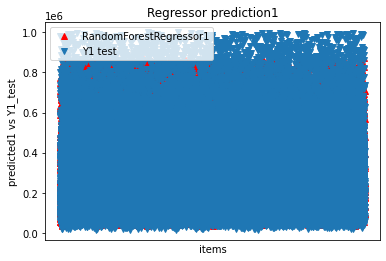

In [149]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

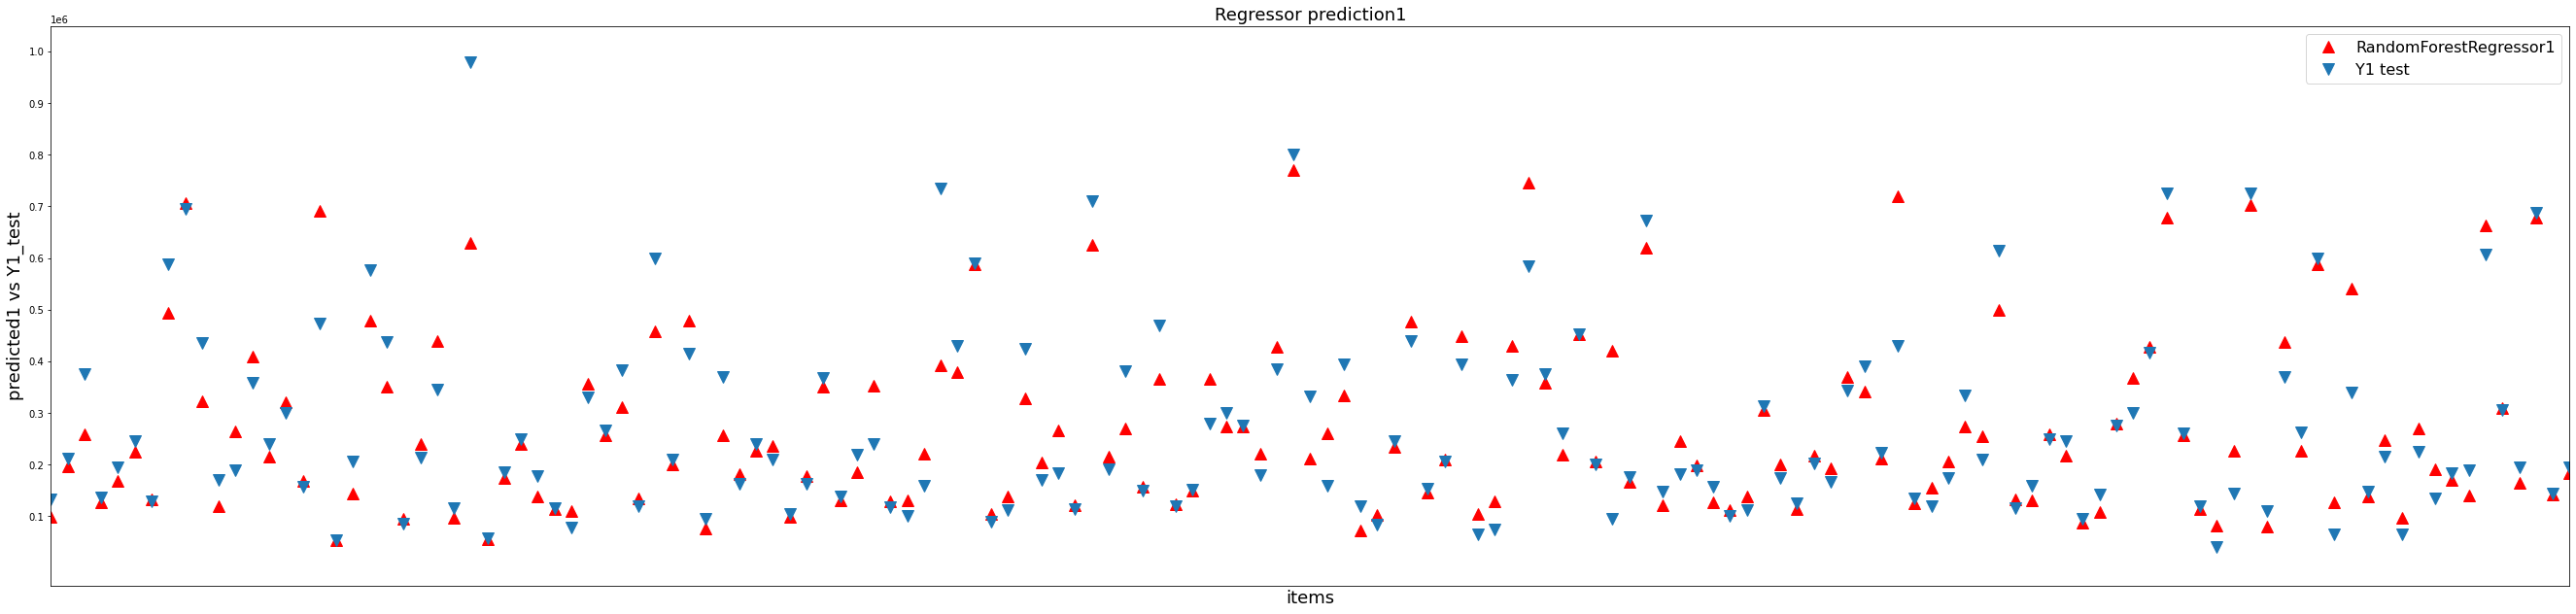

In [150]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [151]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [152]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

62994.43495496029

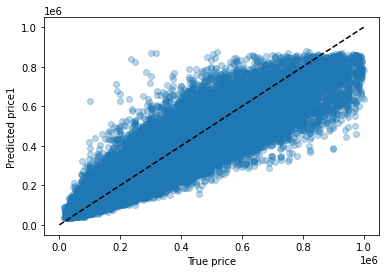

In [153]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [154]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

63616.34672255432

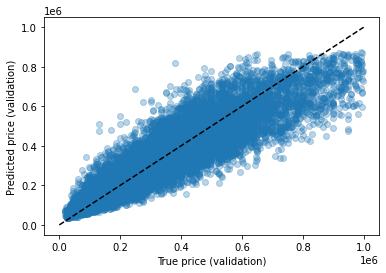

In [155]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()